In [2]:
import osmnx as ox
import matplotlib.pyplot as plt

In [3]:
import networkx as nx
import geopandas as gpd
import pandas as pd

In [8]:
place_name = "Singapore, Central, Singapore"
graph = ox.save_load.load_graphml(filename="Singapore.graphml", folder=None)

# Stores nodes and edges along with other attributes
type(graph)

networkx.classes.multidigraph.MultiDiGraph

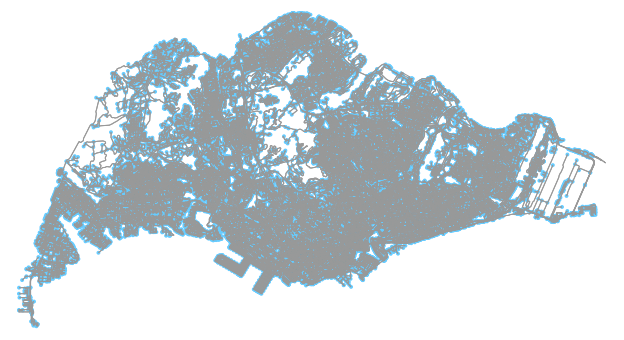

<Figure size 432x288 with 0 Axes>

In [9]:
# Blue == nodes, Gray == edges
fig, ax = ox.plot_graph(graph)
plt.tight_layout()

In [10]:
nodes, edges = ox.graph_to_gdfs(graph, nodes=True, edges=True)
nodes.head()

,y,x,osmid,highway,ref,lon,lat,geometry
5215092740,152051.591021,355258.131264,5215092740,nan,nan,103.6989815,1.3752989,POINT (355258.131 152051.591)
5215092741,152211.319661,355271.971587,5215092741,nan,nan,103.6991051,1.3767437,POINT (355271.972 152211.320)
5215092742,152213.889739,355242.363528,5215092742,nan,nan,103.698839,1.3767668,POINT (355242.364 152213.890)
5215092743,152056.393612,355229.937556,5215092743,nan,nan,103.6987281,1.3753422,POINT (355229.938 152056.394)
5215092748,152221.705949,355161.973808,5215092748,nan,nan,103.6981165,1.3768371,POINT (355161.974 152221.706)


In [6]:
edges.head()

,u,v,key,osmid,lanes,highway,service,oneway,length,geometry,name,maxspeed,bridge,tunnel,ref,access,junction,width,est_width,area
0,5215092740,5215092743,0,646805965,2,service,parking_aisle,False,28.577,"LINESTRING (103.69898 1.37530, 103.69873 1.37534)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5215092740,5215092741,0,"[646806244, 701289234, 701289237, 701289238, 5...",2,service,parking_aisle,False,207.423,"LINESTRING (103.69898 1.37530, 103.69915 1.375...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5215092740,5215092741,1,"[701289240, 538846647, 701289239]",2,service,parking_aisle,False,161.241,"LINESTRING (103.69898 1.37530, 103.69902 1.375...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5215092741,5215092742,0,646806242,2,service,NaN,False,29.692,"LINESTRING (103.69911 1.37674, 103.69884 1.37677)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5215092741,5215092740,0,"[701289240, 701289239, 538846647]",2,service,parking_aisle,False,161.241,"LINESTRING (103.69911 1.37674, 103.69907 1.376...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
print("Coordinate system:", edges.crs)

Coordinate system: +proj=utm +zone=48 +ellps=WGS84 +datum=WGS84 +units=m +no_defs


### Overall stats about road network (needs GPU for heavy computation)

In [12]:
# area = edges_proj.unary_union.convex_hull.area
# stats = ox.basic_stats(graph_proj, area=area)
# extended_stats = ox.extended_stats(graph_proj, ecc=True, bc=True, cc=True)

# for key, value in extended_stats.items():
#     stats[key] = value

In [13]:
# pd.Series(stats)

### Finding shortest route between centroid of map and east-most point (using Djikstra)

In [14]:
# Min-max xy coordinates
edges.bounds.head()

,minx,miny,maxx,maxy
0,355229.937556,152051.591021,355258.131264,152056.393612
1,355258.131264,152049.259189,355296.427990,152211.319661
2,355258.131264,152051.591021,355271.971587,152211.319661
3,355242.363528,152211.319661,355271.971587,152213.889739
4,355258.131264,152051.591021,355271.971587,152211.319661


In [15]:
from shapely.geometry import box

# Boundary Box of entire area
bbox = box(*edges.unary_union.bounds)
print(bbox)

POLYGON ((393157.2096766838 136068.3411761413, 393157.2096766838 162563.911698271, 344880.3021857571 162563.911698271, 344880.3021857571 136068.3411761413, 393157.2096766838 136068.3411761413))


In [16]:
# centroid as starting point
orig_point = bbox.centroid
print(orig_point)

POINT (369018.7559312205 149316.1264372061)


In [17]:
nodes['x'] = nodes.x.astype(float)
maxx = nodes['x'].max()
target_loc = nodes.loc[nodes['x']==maxx, :]

# East-most point
print(target_loc)

target_point = target_loc.geometry.values[0]
print(target_point)

                        y              x       osmid highway  ref         lon  \
1323128900  145502.072777  392336.562243  1323128900     NaN  NaN  104.032248   

                 lat                       geometry  
1323128900  1.316212  POINT (392336.562 145502.073)  
POINT (392336.5622428116 145502.0727771872)


In [18]:
orig_xy = (orig_point.y, orig_point.x)
target_xy = (target_point.y, target_point.x)

orig_node = ox.get_nearest_node(graph, orig_xy, method='euclidean')
target_node = ox.get_nearest_node(graph, target_xy, method='euclidean')

o_closest = nodes.loc[orig_node]
t_closest = nodes.loc[target_node]

In [19]:
print(orig_node)

5698333646


In [20]:
print(target_node)

1323128900


In [21]:
od_nodes = gpd.GeoDataFrame([o_closest, t_closest], geometry='geometry', crs=nodes.crs)

In [22]:
route = nx.shortest_path(G=graph, source=orig_node, target=target_node, weight='length')
print(route) # Prints all nodes that are part of the route

[5698333646, 5698333649, 5698333645, 4000033070, 6734294890, 1318498273, 5698393580, 3784797714, 3998723969, 1318459258, 1318459324, 5698393564, 1318459289, 1125498105, 1125498449, 4749173448, 5267997365, 5698393565, 5698393566, 206089498, 6063308127, 6063308122, 4598549294, 5648108260, 4598549321, 1125498533, 206089496, 5497780246, 243415197, 206089495, 5698520997, 5176761855, 5977871059, 5497450909, 1857011360, 5698520999, 5698521003, 4598784944, 3251145331, 3251145329, 3251145328, 4598447916, 241798854, 241798856, 4312237497, 240417502, 240416976, 4312237385, 4312237372, 4598764074, 243418553, 5953088700, 4745583708, 1867626512, 4598549790, 6956313735, 5251064945, 5251064947, 2579176759, 4745583705, 4598764050, 4598764082, 243418578, 243418661, 5284514579, 1208450955, 5955937830, 1208450933, 5952856604, 248018511, 4935012100, 4598764011, 5701029133, 243418643, 1090502018, 4935012077, 243418636, 4747824503, 1090501760, 5216523569, 5216523549, 1318666873, 4855623508, 1318667027, 17918

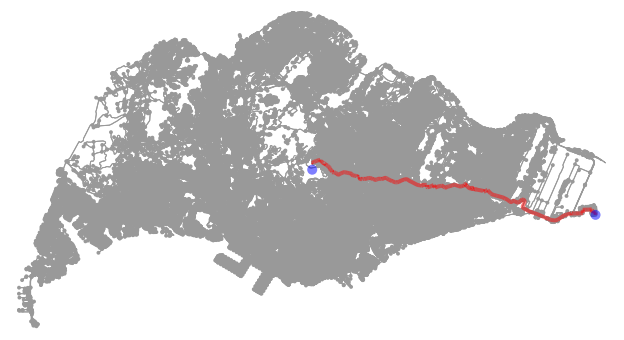

<Figure size 432x288 with 0 Axes>

In [23]:
fig, ax = ox.plot_graph_route(graph, route, origin_point=orig_xy, destination_point=target_xy)
plt.tight_layout()

### We could calculate the time that it takes to cross each road segment by dividing the length of the road segment with the speed limit and calculate optimal routes based on travel times. 